In [13]:
from influxdb_client import InfluxDBClient
from influxdb_client.client.exceptions import InfluxDBError

import datetime
import os, csv
import pandas as pd
import numpy as np

root_folder = r"C:\Develop\py\FluidicsLab\Drafts\bus\books"
config_folder = os.path.join(root_folder, "config")
template_folder = os.path.join(root_folder, "template")
data_folder = os.path.join(root_folder, "data")

connection_file = os.path.join(template_folder, "connection.ini")

# duration
_template = '%Y-%m-%d %H:%M:%S'
_start = datetime.datetime.strptime('2025-07-01 11:00:00', _template)
_stop  = datetime.datetime.strptime('2025-07-02 4:50:00', _template)

data_file = os.path.join(data_folder, f"mcv.volume.csv")

def query_(template):
    param = {
        "_bucket": "ed1f",
        "_start": _start,
        "_stop": _stop, 
        "_every": datetime.timedelta(seconds=1)
    }
    flux_filename = os.path.join(template_folder, f"{template}.flux")

    lf = '\n'
    with open(flux_filename, "r") as f:
        db_query = "".join(f.readlines()).replace(lf, '').strip()

    db_data = None

    client = None
    try:
        client = InfluxDBClient.from_config_file(connection_file)        
        db_data = client.query_api().query_csv(db_query, params=param).to_values()  
        
        print(f'{data_file}')
        with open(data_file, 'w', newline='') as f:
            w = csv.writer(f, quoting=csv.QUOTE_NONNUMERIC)
            w.writerows(db_data)

    except InfluxDBError as ixe:
        print(f"    ERROR {ixe}")
    except Exception as ex:
        print(f"    ERROR {ex}")
    finally:
        if client is not None:
            client.close()


In [74]:
query_("mcv.1")

C:\Develop\py\FluidicsLab\Drafts\bus\books\data\mcv.volume.csv


In [76]:
data = pd.read_csv(data_file, skiprows=[0,1,2], usecols=["_time", "pressure_1", "pressure_2", "volume_1", "volume_2", "velocity_1", "velocity_2", "temperature_1", "temperature_2","airsupply_2"])

t = pd.to_datetime(data["_time"]).values
V1, V2 = data["volume_1"].values, data["volume_2"].values
P1, P2 = data["pressure_1"].values, data["pressure_2"].values
R1, R2 = data["velocity_1"].values, data["velocity_2"].values
T1, T2 = data["temperature_1"].values, data["temperature_2"].values

A = data["airsupply_2"].values

data.describe()

,pressure_1,temperature_1,velocity_1,volume_1,airsupply_2,pressure_2,temperature_2,velocity_2,volume_2
count,61037.000000,61037.000000,61037.000000,61037.000000,61037.000000,61037.000000,61037.000000,61037.000000,61037.000000
mean,700.000001,28.016847,-0.000369,4.824632,10102.942149,699.674611,27.911320,-0.000578,5.535068
std,0.092796,0.468748,0.891897,0.004112,143.335907,0.208456,0.460178,0.013972,0.000708
min,699.729901,27.110364,-1.965000,4.818000,9791.100803,699.331604,27.020300,-0.051000,5.532100
25%,699.907520,27.679688,-0.880700,4.820000,9992.777286,699.457886,27.575928,-0.010300,5.534778
50%,700.001068,27.885010,-0.021600,4.826000,10078.279977,699.677646,27.781665,-0.000600,5.535000
75%,700.091870,28.342407,0.885200,4.826900,10205.389569,699.884949,28.222388,0.009000,5.535700
max,700.196350,29.021362,2.909100,4.835000,10498.214667,700.167664,28.854492,0.049000,5.537000


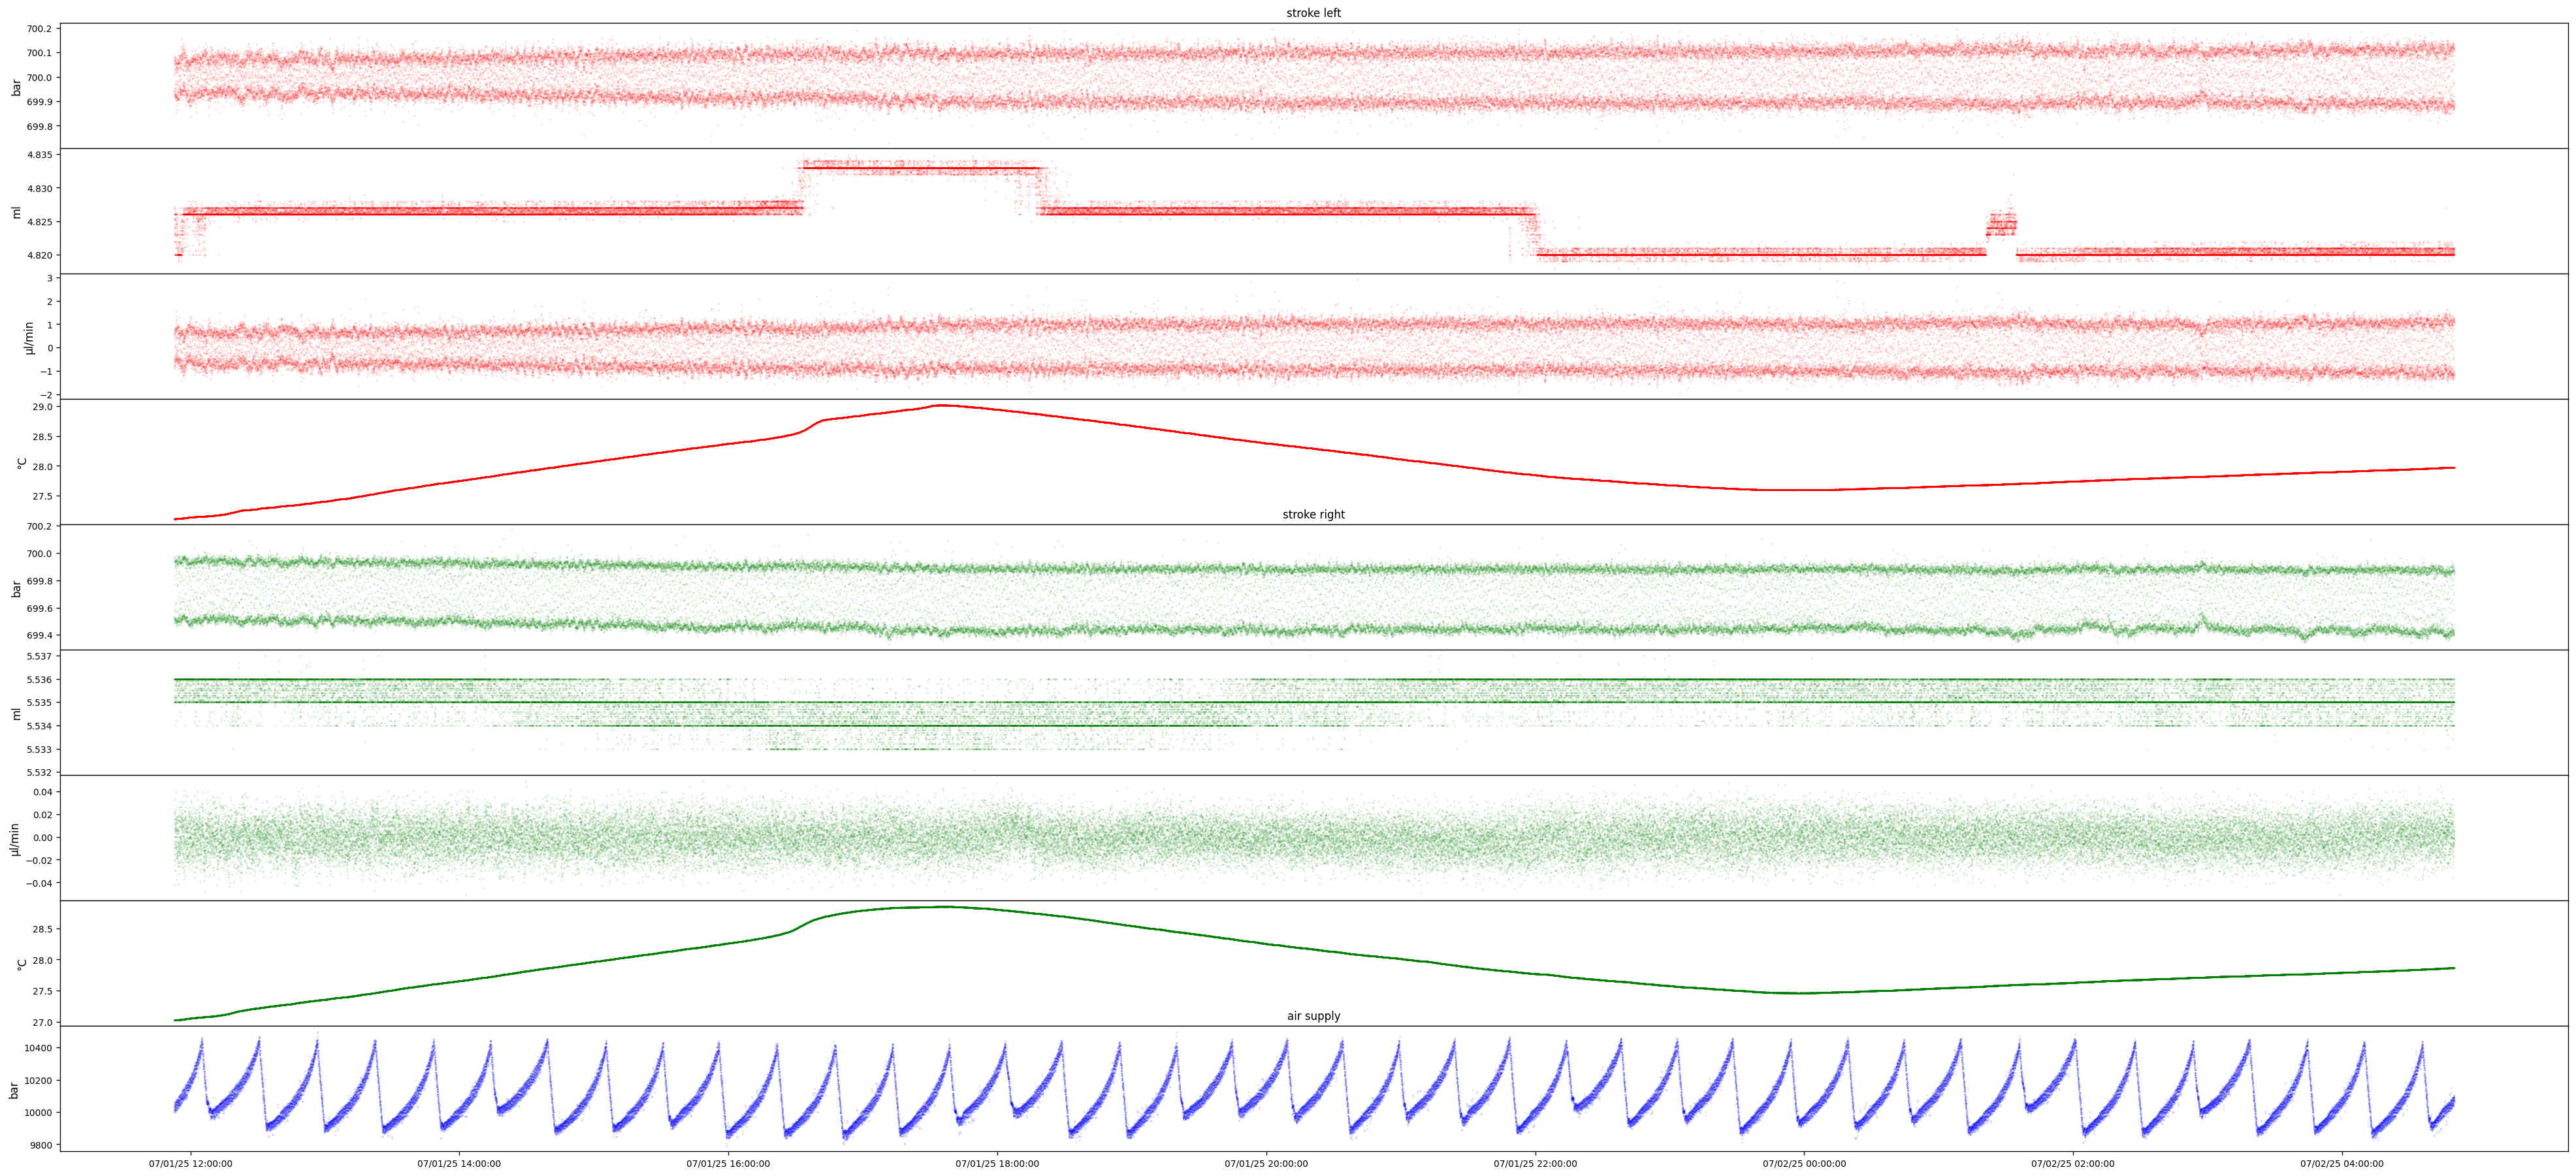

In [89]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates

style = "seaborn-v0_8-dark-palette"
plt.style.use(style)

mpl.rcParams['backend'] = 'qtagg'
mpl.rcParams['xtick.labelsize'] = 'small'
mpl.rcParams['ytick.labelsize'] = 'small'

n = 8 +1

fig, ax = plt.subplots(n,1, sharex=True)
fig.set_size_inches(40,n*2)

dpi = 120
fig.set_dpi(dpi)

ax[0].set_title(f"stroke left", fontdict={ "size": 10 })

for i,D in enumerate([P1,V1,R1,T1]):
    ax[i].plot(t,D, ".", ms=.2, c="red")

ax[4].set_title(f"stroke right", fontdict={ "size": 10 })

for i,D in enumerate([P2,V2,R2,T2]):
    ax[i+4].plot(t,D, ".", ms=.2, c="green")

ax[8].set_title(f"air supply", fontdict={ "size": 10 })
ax[8].plot(t,A, ".", ms=.2, c="blue")

ax[8].xaxis.set_major_formatter(mdates.DateFormatter('%D %H:%M:%S'))
plt.setp(ax[8].get_xticklabels(), rotation=0)

for i,label in enumerate(["bar","ml","µl/min","°C","bar","ml","µl/min","°C", "bar"]):
    ax[i].set_ylabel(label)

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.0)

plt.show()
plt.close()


In [90]:
import tsfresh 

for col in ["pressure_1","pressure_2","volume_1","volume_2","temperature_1","temperature_2","airsupply_2"]:

    print(col)

    rc = tsfresh.feature_extraction.feature_calculators.linear_trend(data[col].values, param=[
        {"attr": "slope"},
        {"attr": "intercept"},
        {"attr": "rvalue"},     # correlation coeff
        {"attr": "pvalue"},     # independence of the regression model; >= 0.05 model is not realy significant
        {"attr": "stderr"}
        ])
    
    print(rc)

    rc = tsfresh.feature_extraction.feature_calculators.autocorrelation(data[col].values, lag=1)
    print(rc)

pressure_1
[('attr_"slope"', np.float64(-4.164845839934557e-08)), ('attr_"intercept"', np.float64(700.0012716210219)), ('attr_"rvalue"', np.float64(-0.007908130235186167)), ('attr_"pvalue"', np.float64(0.050731158534660474)), ('attr_"stderr"', np.float64(2.1316802573180963e-08))]
0.6937792078793207
pressure_2
[('attr_"slope"', np.float64(-9.884973364005977e-07)), ('attr_"intercept"', np.float64(699.7047774676748)), ('attr_"rvalue"', np.float64(-0.0835539277850382)), ('attr_"pvalue"', np.float64(5.432536350758068e-95)), ('attr_"stderr"', np.float64(4.771971936749003e-08))]
0.6928633485614867
volume_1
[('attr_"slope"', np.float64(-1.6577604859055058e-07)), ('attr_"intercept"', np.float64(4.829691154298147)), ('attr_"rvalue"', np.float64(-0.7103711551203536)), ('attr_"pvalue"', np.float64(0.0)), ('attr_"stderr"', np.float64(6.648337815067053e-10))]
0.9870967696735417
volume_2
[('attr_"slope"', np.float64(4.421825873848289e-09)), ('attr_"intercept"', np.float64(5.53493303231329)), ('attr_"

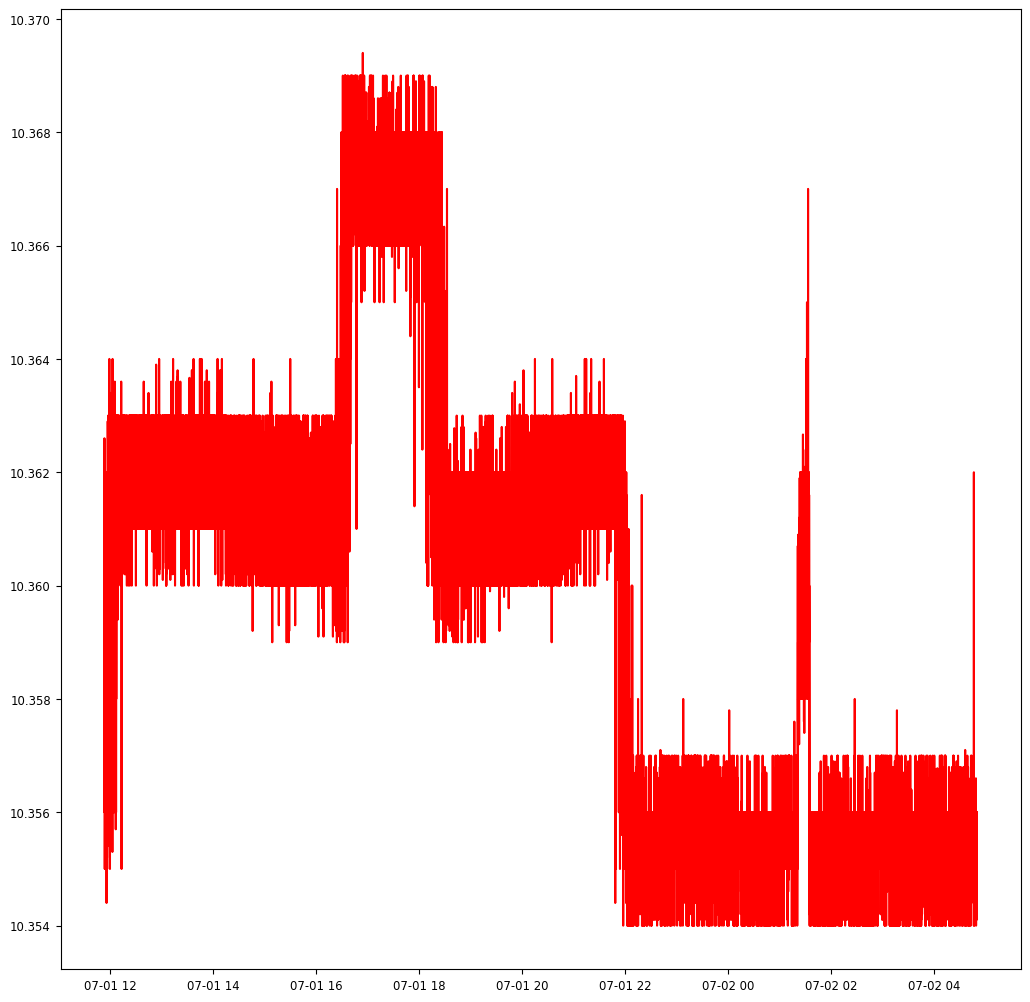

In [60]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl

style = "seaborn-v0_8-dark-palette"
plt.style.use(style)

mpl.rcParams['backend'] = 'qtagg'
mpl.rcParams['xtick.labelsize'] = 'small'
mpl.rcParams['ytick.labelsize'] = 'small'


fig, ax = plt.subplots(1,1, sharex=True)
fig.set_size_inches(12,12)

dpi = 100
fig.set_dpi(dpi)

ax.set_title(f"", fontdict={ "size": 10 })

ax.plot(t, V1+V2, "-", ms=.5, c="red")

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.0)

plt.show()
plt.close()